# Hippocampus Neurogenesis Toy Model

In [1]:
from ipywidgets import interact, FloatSlider
import numpy as np
import scipy as sp
import scipy.integrate

import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn
seaborn.set_context('notebook')

## Some helper functions:

In [2]:
import ipywidgets

In [11]:
def rloss(p):
    r1loss = (p['p111'] - p['p122']) * p['r1'] - p['r12']
    r2loss = 1 / p['N20'] * (p['r222'] + ((1 + p['p122'] - p['p111']) * p['r1'] + p['r12']) * p['N10'])
    return r1loss, r2loss

def p112(p):
    return 1 - p['p111'] - p['p122']

def set_color(p):
    if p112(p) < 0.0:
        color = 'red'
    elif sp.any(sp.array(rloss(p)) < 0.0):
        color = 'red'
    else:
        color = 'black'
    return color

def do_interact():
    interact(plot_cell_numbers, 
         N10 = FloatSlider(p['N10'], min = 100.0, max = 10000.0, step = 100.0), 
         N20 = FloatSlider(p['N20'], min = 100.0, max = 10000.0, step = 100.0), 
         p111 = FloatSlider(p['p111'], min = 0.0, max = 1.0, step = 0.1), 
         p122 = FloatSlider(p['p122'], min = 0.0, max = 1.0, step = 0.1), 
         r12 = FloatSlider(p['r12'], min = 0.0, max = 1.0, step = 0.1), 
         f1 = FloatSlider(p['f1'], min = 0.0, max = 1.0, step = 0.1), 
         f2 = FloatSlider(p['f2'], min = 0.0, max = 1.0, step = 0.1), 
         t_max = FloatSlider(p['t_max'], min = 0.1, max = 20.0, step = 0.1), 
        );

## Defining the model

In [4]:
def func(y, t0, p):
    r1loss, r2loss = rloss(p)
    
    dy0dt = ((p['p111'] - p['p122']) * p['r1'] - p['r12'] - r1loss) * y[0]
    dy1dt = ((1 + p['p122'] - p['p111']) * p['r1'] + p['r12']) * y[0] + (p['r222'] - r2loss) * y[1]
    return sp.array([dy0dt, dy1dt])

In [5]:
def solve_ode(p):
    t = sp.linspace(p['t_min'], p['t_max'], 100)
    
    N0 = sp.array([p['N10'], p['N20']])
    f = sp.array([p['f1'], p['f2']])
    u0 = (1.0 - f) * N0
    l0 = f * N0
    
    u = sp.integrate.odeint(func, u0, t, args = (p,))
    u1, u2 = u[:,0], u[:,1]
    l = sp.integrate.odeint(func, l0, t, args = (p,))
    l1, l2 = l[:,0], l[:,1]
    return t, u1, u2, l1, l2

## Model Parameters

In [13]:
p = dict(N10 = 1000.0,
         N20 = 2000.0,
         
         r1 = sp.log(2) / 1.0,
         
         p111 = 0.5,
         p122 = 0.3,
         
         r12 = 0.0,
         
         r222 = 0.0,
         
         f1 = 0.5,
         f2 = 0.1,

         t_min = 0.0,
         t_max = 10.0,
         
        )

## Plotting the model prediction

In [14]:
def plot_cell_numbers(**keyw):
    p.update(keyw)
    t, u1, u2, l1, l2 = solve_ode(p)
    
    fig.suptitle('r1loss = {0:.1f}, r2loss = {1:.1f}, p112 = {2:.2f}'.format(*rloss(p), p112(p)), color = set_color(p))
    
    lNtot1[0].set_data(t, u1 + l1)
    lNtot2[0].set_data(t, u2 + l2)
    lratio1[0].set_data(t, l1 / (u1 + l1))
    lratio2[0].set_data(t, l2 / (u2 + l2))
    lN1[0].set_data(t, u1)
    lN2[0].set_data(t, u2)
    ll1[0].set_data(t, l1)
    ll2[0].set_data(t, l2)
    
    ax[1,1].set_xlim(p['t_min'], p['t_max'])
    for cax in [ax[0, 0], ax[1, 0], ax[1, 1]]:
        cax.set_ylim(0, 1.1 * max(p['N10'], p['N20']))

In [15]:
t, u1, u2, l1, l2 = solve_ode(p)

<IPython.core.display.Javascript object>


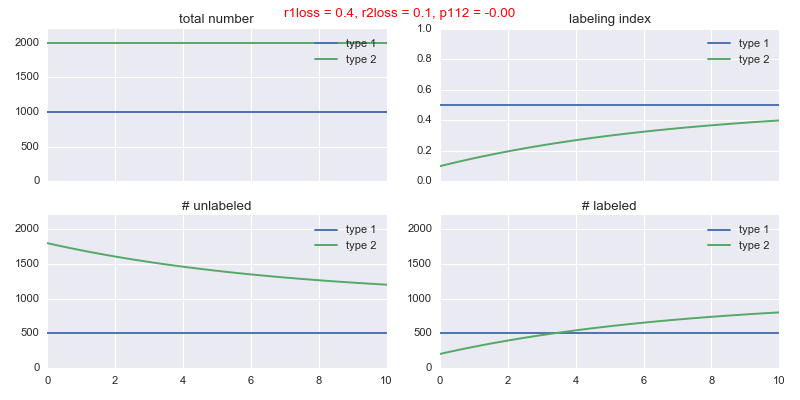

In [16]:
fig, ax = plt.subplots(2, 2, figsize = (10,5), sharex = True)

fig.suptitle('r1loss = {0:.1f}, r2loss = {1:.1f}, p112 = {2:.2f}'.format(*rloss(p), 1 - p['p111'] - p['p122']), color = set_color(p))

lNtot1 = ax[0, 0].plot(t, u1 + l1, label = 'type 1')
lNtot2 = ax[0, 0].plot(t, u2 + l2, label = 'type 2')

ax[0, 0].legend()
ax[0, 0].set_title('total number')

lratio1 = ax[0, 1].plot(t, l1 / (u1 + l1), label = 'type 1')
lratio2 = ax[0, 1].plot(t, l2 / (u2 + l2), label = 'type 2')

ax[0, 1].legend()
ax[0, 1].set_title('labeling index')
ax[0, 1].set_ylim(0, 1)

lN1 = ax[1, 0].plot(t, u1, label = 'type 1')
lN2 = ax[1, 0].plot(t, u2, label = 'type 2')

ax[1, 0].legend()
ax[1, 0].set_title('# unlabeled')

ll1 = ax[1, 1].plot(t, l1, label = 'type 1')
ll2 = ax[1, 1].plot(t, l2, label = 'type 2')

ax[1, 1].legend()
ax[1, 1].set_title('# labeled')

for cax in [ax[0, 0], ax[1, 0], ax[1, 1]]:
    cax.set_ylim(0, 1.1 * max(p['N10'], p['N20']))
    

plt.tight_layout()

plt.show()

In [12]:
do_interact()